<a href="https://colab.research.google.com/github/ManavFCB/Crowd-Counting/blob/master/Crowd_Counting_P1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import cv2
from google.colab.patches import cv2_imshow
import numpy as np
import os
from google.colab import drive
import pandas as pd
from scipy.ndimage import gaussian_filter
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.neighbors import KernelDensity
import matplotlib.pyplot as plt

In [ ]:
drive.mount('/content/gdrive/', force_remount=True)

Mounted at /content/gdrive/


In [ ]:
path = '/content/gdrive/MyDrive/fdst/train_data'  #replace with test_data for performing svd on test data

In [ ]:
#Decided on the on the rank of the matrix S. Found that 150 works best. However this has to backed with mathematical evidence.
rank = 150
for root, dirs, files in os.walk(path):
    print(root)
    if 'svd' not in root and 'svd' not in dirs:
        for file in files:
            if 'jpg' in file and "_" not in file:
                img = cv2.imread(os.path.join(root, file), cv2.IMREAD_GRAYSCALE)  #don't require them to be RGB. One channel should work
                U, S, V = np.linalg.svd(img, full_matrices = False)
                reconst_img = np.matmul(np.matmul(U[:, :rank], np.diag(S[:rank])), V[:rank, :])
                if not os.path.isdir(os.path.join(root, "svd_" + str(rank))):
                  print("created:"+os.path.join(root, "svd_" + str(rank)))
                  os.mkdir(os.path.join(root, "svd_" + str(rank)))
                cv2.imwrite(os.path.join(root, "svd_"+ str(rank), file), reconst_img)
    else:
      print("already exists")
      continue

### **Kernel Density Estimation**

**a) generate annotation map for each training frame**

**1. trial on a sample image**

In [ ]:
img = cv2.imread("/content/gdrive/MyDrive/fdst/train_data/53/annotation_map_5/001.jpg", cv2.IMREAD_GRAYSCALE)

In [ ]:
img_json = pd.read_json("/content/gdrive/MyDrive/fdst/train_data/1/001.json")

ValueError: ignored

In [ ]:
annotations = img_json.iloc[2][img_json.columns[0]]

In [ ]:
density_img = np.zeros(img.shape, dtype = 'float32')

In [ ]:
for annotation in annotations:
  x = annotation['shape_attributes']['x']
  y = annotation['shape_attributes']['y']
  width = annotation['shape_attributes']['width']
  height = annotation['shape_attributes']['height']
  density_img[y, x] = 255

NameError: ignored

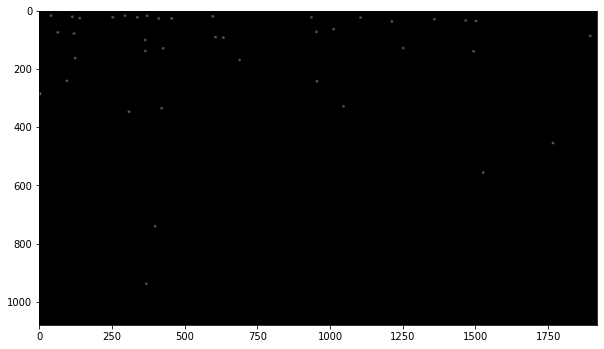

In [ ]:
plt.figure(figsize = (10, 20))
plt.imshow(img, cmap = 'gray')
map = gaussian_filter(density_img, sigma = (2, 2), order = 0)
plt.imshow(map, cmap = 'gray')

In [ ]:
plt.figure(figsize = (10, 20))
plt.imshow(density_img)
map = gaussian_filter(density_img, sigma = (5, 5), order = 0)
plt.imshow(map, cmap = 'gray')

NameError: ignored

<Figure size 720x1440 with 0 Axes>

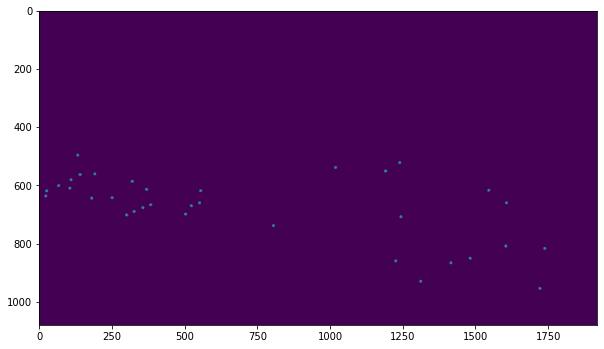

In [ ]:
plt.figure(figsize = (10, 20))
plt.imshow(img)

**2. Generation of the same on all training frames**

In [ ]:
height = 1080
width = 1920
for root, dirs, files in os.walk(path):
    print(root)
    if 'svd_' not in root and 'svd_' not in dirs and "done" not in root:
        for file in files:
            if 'json' in file and "_" not in file:
                img_json = pd.read_json(os.path.join(root, file))
                annotations = img_json.iloc[2][img_json.columns[0]]
                annotation_map = np.zeros(img.shape, dtype = 'int')
                for annotation in annotations:
                  x = annotation['shape_attributes']['x']
                  y = annotation['shape_attributes']['y']
                  width = annotation['shape_attributes']['width']
                  height = annotation['shape_attributes']['height']
                  annotation_map[y, x] = 255
                  maps = []
                  maps.append(gaussian_filter(annotation_map, sigma = (1, 1), order = 0))
                  maps.append(gaussian_filter(annotation_map, sigma = (5, 5), order = 0))
                if not os.path.isdir(os.path.join(root, "annotation_map_1")):
                  print("created:"+os.path.join(root, "annotation_map_1"))
                  os.mkdir(os.path.join(root, "annotation_map_1"))
                if not os.path.isdir(os.path.join(root, "annotation_map_5")):
                  print("created:"+os.path.join(root, "annotation_map_5"))
                  os.mkdir(os.path.join(root, "annotation_map_5"))
                img_name = file.replace("json", "jpg")
                cv2.imwrite(os.path.join(root, "annotation_map_1", img_name), maps[0])
                cv2.imwrite(os.path.join(root, "annotation_map_5", img_name), maps[1])
    else:
      print("already exists")
      continue

/content/gdrive/MyDrive/fdst/train_data
/content/gdrive/MyDrive/fdst/train_data/53
/content/gdrive/MyDrive/fdst/train_data/53/svd_150
already exists
/content/gdrive/MyDrive/fdst/train_data/53/annotation_map_1
/content/gdrive/MyDrive/fdst/train_data/53/annotation_map_5
/content/gdrive/MyDrive/fdst/train_data/52
/content/gdrive/MyDrive/fdst/train_data/52/svd_150
already exists
/content/gdrive/MyDrive/fdst/train_data/52/annotation_map_1
/content/gdrive/MyDrive/fdst/train_data/52/annotation_map_5
/content/gdrive/MyDrive/fdst/train_data/51
created:/content/gdrive/MyDrive/fdst/train_data/51/annotation_map_1
created:/content/gdrive/MyDrive/fdst/train_data/51/annotation_map_5
/content/gdrive/MyDrive/fdst/train_data/51/svd_150
already exists
/content/gdrive/MyDrive/fdst/train_data/47
created:/content/gdrive/MyDrive/fdst/train_data/47/annotation_map_1
created:/content/gdrive/MyDrive/fdst/train_data/47/annotation_map_5
/content/gdrive/MyDrive/fdst/train_data/47/svd_150
already exists
/content/gdr

KeyboardInterrupt: ignored

**Training a CNN to learn the density plots**

**a) Train on sigma = 5**

In [ ]:
y_train = []
x_train = []
x_train_resized = []
gt_train_list = []

In [ ]:
gt_train = pd.read_csv("/content/gdrive/MyDrive/fdst/train_data/ground_truth_train.csv")
gt_test = pd.read_csv("/content/gdrive/MyDrive/fdst/test_data/ground_truth_test.csv")

def imgToGT(df):
  dic = {}
  length = len(df)
  for i in range(length):
    dic[df.iloc[i, 0]] = df.iloc[i, 1]
  return dic

gt_train_dic = imgToGT(gt_train)
gt_test_dic = imgToGT(gt_test)

In [ ]:
path = "/content/gdrive/MyDrive/fdst/train_data"
cnt = 0
for root, dirs, files in os.walk(path):
  if "annotation_map_5" in root:
    print(root)
    for file in files:
      if cnt < 7000:
        annot_img = cv2.imread(os.path.join(root, file), cv2.IMREAD_GRAYSCALE)
        annot_img_resize = cv2.resize(annot_img, (640, 360))
        _, annot_img_resize = cv2.threshold(annot_img_resize, 0, 1, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
        parent_dir = os.path.dirname(root)
        svd_dir = os.path.join(parent_dir, 'svd_150')
        if os.path.join(parent_dir, file) in gt_train_dic.keys():
          gt = gt_train_dic[os.path.join(parent_dir, file)]
          train_img = cv2.imread(os.path.join(svd_dir, file), cv2.IMREAD_GRAYSCALE)
          if train_img is not None:
            train_img_resize = cv2.resize(train_img, (640, 360))
            x_train_resized.append(train_img_resize)
            # _, train_img_resize = cv2.threshold(train_img_resize, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
            y_train.append(annot_img_resize)
            x_train.append(train_img_resize)
            gt_train_list.append(gt)
            cnt += 1
      else:
        break


/content/gdrive/MyDrive/fdst/train_data/91/annotation_map_5
/content/gdrive/MyDrive/fdst/train_data/92/annotation_map_5
/content/gdrive/MyDrive/fdst/train_data/98/annotation_map_5
/content/gdrive/MyDrive/fdst/train_data/87/annotation_map_5
/content/gdrive/MyDrive/fdst/train_data/88/annotation_map_5
/content/gdrive/MyDrive/fdst/train_data/83/annotation_map_5
/content/gdrive/MyDrive/fdst/train_data/93/annotation_map_5
/content/gdrive/MyDrive/fdst/train_data/97/annotation_map_5
/content/gdrive/MyDrive/fdst/train_data/86/annotation_map_5
/content/gdrive/MyDrive/fdst/train_data/96/annotation_map_5
/content/gdrive/MyDrive/fdst/train_data/82/annotation_map_5
/content/gdrive/MyDrive/fdst/train_data/81/annotation_map_5


KeyboardInterrupt: ignored

In [ ]:
len(x_train)

1704

In [ ]:
x_train = np.array(x_train)
y_train = np.array(y_train)

In [ ]:
# x_val, y_val, gt_val = x_train[int(0.8 * len(x_train)):len(x_train)], y_train[int(0.8 * len(y_train)):len(y_train)], gt_train_list[int(0.8 * len(gt_train_list)):len(gt_train_list)]
# x_train, y_train, gt_train = x_train[:int(0.8 * len(x_train))], y_train[:int(0.8 * len(y_train))], gt_train_list[:int(0.8 * len(gt_train_list))]

In [ ]:
# x_val_resized = x_train_resized[int(0.8 * len(x_train)):]
# x_train_resized = x_train_resized[:int(0.8 * len(x_train))]

In [ ]:
x_test = []
gt_test_list = []
x_test_resized = []
y_test = []
path = "/content/gdrive/MyDrive/fdst/test_data"
cnt = 0
for root, dirs, files in os.walk(path):
  if "annotation_map_5" in root:
    print(root)
    for file in files:
      if cnt < 3000:
        annot_img = cv2.imread(os.path.join(root, file), cv2.IMREAD_GRAYSCALE)
        annot_img_resize = cv2.resize(annot_img, (640, 360))
        _, annot_img_resize = cv2.threshold(annot_img_resize, 0, 1, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
        parent_dir = os.path.dirname(root)
        svd_dir = os.path.join(parent_dir, 'svd_150')
        if os.path.join(parent_dir, file) in gt_test_dic.keys():
          gt = gt_test_dic[os.path.join(parent_dir, file)]
          test_img = cv2.imread(os.path.join(svd_dir, file), cv2.IMREAD_GRAYSCALE)
          if test_img is not None:
            test_img_resize = cv2.resize(test_img, (640, 360))
            x_test_resized.append(test_img_resize)
            # _, test_img_resize = cv2.threshold(test_img_resize, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
            y_test.append(annot_img_resize)
            x_test.append(test_img_resize)
            gt_test_list.append(gt)
            cnt += 1
      else:
        break


/content/gdrive/MyDrive/fdst/test_data/85/annotation_map_5
/content/gdrive/MyDrive/fdst/test_data/89/annotation_map_5
/content/gdrive/MyDrive/fdst/test_data/9/annotation_map_5
/content/gdrive/MyDrive/fdst/test_data/94/annotation_map_5
/content/gdrive/MyDrive/fdst/test_data/90/annotation_map_5
/content/gdrive/MyDrive/fdst/test_data/84/annotation_map_5
/content/gdrive/MyDrive/fdst/test_data/99/annotation_map_5
/content/gdrive/MyDrive/fdst/test_data/80/annotation_map_5
/content/gdrive/MyDrive/fdst/test_data/95/annotation_map_5
/content/gdrive/MyDrive/fdst/test_data/79/annotation_map_5
/content/gdrive/MyDrive/fdst/test_data/75/annotation_map_5
/content/gdrive/MyDrive/fdst/test_data/74/annotation_map_5
/content/gdrive/MyDrive/fdst/test_data/69/annotation_map_5
/content/gdrive/MyDrive/fdst/test_data/70/annotation_map_5


KeyboardInterrupt: ignored

In [ ]:
x_test = np.array(x_test)
gt_test_list = np.array(gt_test_list)
y_test = np.array(y_test)

In [ ]:
len(y_test)

2099

In [ ]:
#Convolution block for the UNet (for Downsampling)
class UNet:
  def conv(self,x, filters, down_kernel, kernel_size = (3, 3), padding = 'same', strides = 1):
    c = tf.keras.layers.Convolution2D(filters, kernel_size, strides, activation = 'relu', padding = padding)(x)
    c = tf.keras.layers.Convolution2D(filters, kernel_size, strides, activation = 'relu', padding = padding)(c)
    b = tf.keras.layers.BatchNormalization()(c)
    m = tf.keras.layers.MaxPool2D(down_kernel)(b)
    return b, m

  # Function to define the bottleneck layer (last layer in Encoder)
  def bottleneck(self, x, filters, kernel_size = (3, 3), padding = 'same', strides = 1):
    c = tf.keras.layers.Convolution2D(filters, kernel_size, strides, activation = 'relu', padding = padding)(x)
    c = tf.keras.layers.Convolution2D(filters, kernel_size, strides, activation = 'relu', padding = padding)(c)
    b = tf.keras.layers.BatchNormalization()(c)
    return b

  # helps with concatenating the upsampling and downsampled layers (smaller and larger respectively)
  # same number of pixels are cut from top and bottom. Likewise left and right
  def get_crop(self, c, u):
    height = c.shape[1] - u.shape[1]
    if height % 2 == 0:
      top_crop, bottom_crop = height // 2, height // 2
    else:
      top_crop, bottom_crop = int(height / 2), int(height / 2) + 1
    width = c.shape[2] - u.shape[2]
    if width % 2 == 0:
      left_crop, right_crop = width // 2, width // 2
    else:
      left_crop, right_crop = int(width // 2), int(width // 2) + 1
    
    return (top_crop, bottom_crop), (left_crop, right_crop)


  # Function to upsample, concatenate and convolve (Decoding layer)
  def upconv(self, x, skip, filters, up_kernel, kernel_size = (3, 3), padding = 'same', strides = 1):
    ups = tf.keras.layers.Conv2DTranspose(filters, (2, 2), padding = padding, strides = up_kernel)(x)
    height, width = self.get_crop(skip, ups)
    skip = tf.keras.layers.Cropping2D(cropping = (height, width))(skip)
    concat = tf.keras.layers.Concatenate(axis = 3)([ups, skip])
    c = tf.keras.layers.Convolution2D(filters, kernel_size, strides, activation = 'relu', padding = padding)(concat)
    c = tf.keras.layers.Convolution2D(filters, kernel_size, strides, activation = 'relu', padding = padding)(c)
    b = tf.keras.layers.BatchNormalization()(c)
    return b

  # Function to build the UNet Model
  def build(self):
    filters = [64, 128, 256, 512, 1024]
    kernel = [2, 5]
    input = tf.keras.layers.Input((360, 640))
    reshape = tf.keras.layers.Reshape((360, 640, 1))(input)
    bn = tf.keras.layers.BatchNormalization()(reshape)
    c1, m1 = self.conv(bn, filters[0], kernel[0])
    c2, m2 = self.conv(m1, filters[1], kernel[0])
    c3, m3 = self.conv(m2, filters[2], kernel[0])
    c4, m4 = self.conv(m3, filters[3], kernel[1])
    c5 = self.bottleneck(m4, filters[4])
    u1 = self.upconv(c5, c4, filters[3], kernel[1])
    u2 = self.upconv(u1, c3, filters[2], kernel[0])
    u3 = self.upconv(u2, c2, filters[1], kernel[0])
    u4 = self.upconv(u3, c1, filters[0], kernel[0])
    out = tf.keras.layers.Conv2D(1, 1, padding = 'same', activation = 'sigmoid', dtype = 'float32')(u4)
    out = out * np.max(y_train)
    out = tf.keras.layers.Reshape((360, 640))(out)
    return tf.keras.Model(input, out)

In [ ]:
def loss(y_true, y_pred):
  print(y_true)
  print(y_pred)
  l = tf.keras.losses.BinaryCrossentropy()(y_true, y_pred, tf.keras.losses.Reduction.SUM) + 1 - tf.reduce_sum(tf.image.ssim(target, pred, 255.0))
  return l

In [ ]:
unet = UNet()
unet = unet.build()
unet.compile(optimizer = 'adam', loss = tf.keras.losses.BinaryCrossentropy())
print(unet.summary())

In [ ]:
unet = tf.keras.models.load_model("/content/gdrive/MyDrive/fdst/unet_anmap_360x640_binarized_op.h5")
# callbacks = tf.keras.callbacks.EarlyStopping(patience = 5)
# unet.fit(x_train, y_train,
#                 epochs = 40,
#                 batch_size = 10, 
#                 validation_data = (x_test, y_test), 
#                 callbacks = callbacks,
#                 shuffle=True)

In [ ]:
unet.save("/content/gdrive/MyDrive/fdst/unet_anmap_360x640_binarized_op.h5")

In [ ]:
pred = unet.predict(x_test, batch_size = 16)
pred = 255 * pred
pred = pred.astype('uint8')

In [ ]:
a = pred[252]
a = np.reshape(a, (a.shape[0], a.shape[1]))
# _, a = cv2.threshold(a, 0, 1, cv2.THRESH_BINARY+cv2.THRESH_OTSU

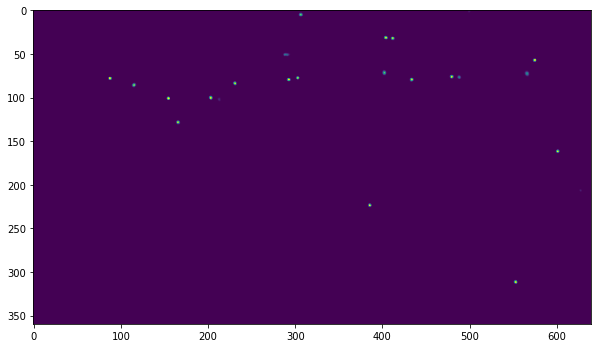

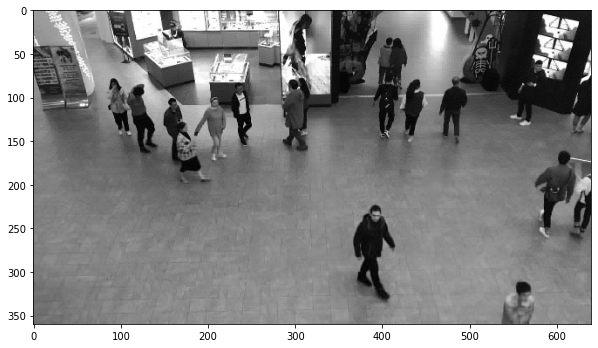

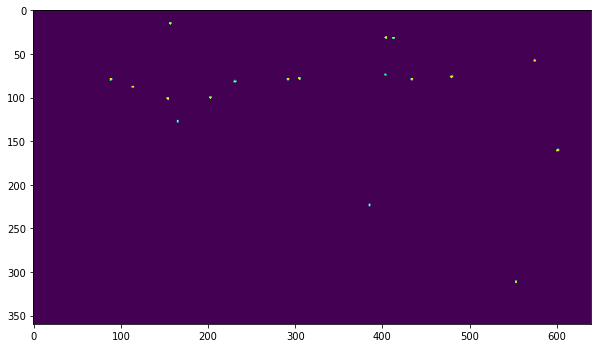

In [ ]:
plt.figure(figsize = (10, 20))
plt.imshow(a)
t = x_test[252]
plt.figure(figsize=(10, 20))
plt.imshow(t.reshape(t.shape[0], t.shape[1]), cmap = 'gray')
gt = y_test[252]
plt.figure(figsize=(10, 20))
plt.imshow(gt.reshape(gt.shape[0], gt.shape[1]))

In [ ]:
def resize_img(x1):
  for i in range(x1.shape[0]):
    _, x1[i,:,:] = cv2.threshold(x1[i,:,:], 0, 1, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
  return x1 

In [ ]:
x2 = resize_img(pred.astype('uint8'))
x2 = np.reshape(x2, (x2.shape[0], x2.shape[1], x2.shape[2]))


# sums_train, sums_test, sums_pred = sums(y_train), sums(y_test), sums(x2)
# f_train, f_test = sums_train / gt_train_list, sums_test / gt_test_list

In [ ]:
class CNN:
# Function to build convolution blocks (convolution + Batch Normalization + Downsampling)
  def densitytogtConv(self, x, filters, kernel_size = 2, strides = 1):
    c = tf.keras.layers.Conv2D(filters, kernel_size, strides, activation='relu', padding = 'same')(x)
    # c = tf.keras.layers.Conv2D(filters, kernel_size, strides, activation='relu', padding = 'same')(c)
    b = tf.keras.layers.BatchNormalization()(c)
    m = tf.keras.layers.MaxPool2D((2, 2))(b)
    return m

  # Function to build Fully Connected Layers with Dropouts
  def densitytogtFc(self, x):
    f1 = tf.keras.layers.Dense(2048, activation='relu')(x)
    f1 = tf.keras.layers.Dense(512, activation='relu')(f1)
    f1 = tf.keras.layers.Dense(256, activation='relu')(f1)
    d = tf.keras.layers.Dropout(0.2)(f1)
    f2 = tf.keras.layers.Dense(128, activation='relu')(f1)
    d = tf.keras.layers.Dropout(0.2)(f2)
    f3 = tf.keras.layers.Dense(32, activation='relu')(f2)
    f4 = tf.keras.layers.Dense(1, activation='softplus')(f3)
    return f4

  def densitytogt(self):
    f = [4, 8, 16, 32, 64]
    k = [2, 3]
    inp = tf.keras.layers.Input((360, 640))
    r = tf.keras.layers.Reshape((360, 640, 1))(inp)
    m1 = self.densitytogtConv(r, f[0])
    m2 = self.densitytogtConv(m1, f[1])
    m3 = self.densitytogtConv(m2, f[2])
    m4 = self.densitytogtConv(m3, f[3])
    m5 = self.densitytogtConv(m4, f[4])
    fl = tf.keras.layers.Flatten()(m5)
    d = tf.keras.layers.Dropout(0.2)(fl)
    output = self.densitytogtFc(d)
    return tf.keras.Model(inp, output)

In [ ]:
cnn = CNN()
reg = cnn.densitytogt()

In [ ]:
reg.summary()

Model: "model_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        [(None, 360, 640)]        0         
_________________________________________________________________
reshape_9 (Reshape)          (None, 360, 640, 1)       0         
_________________________________________________________________
conv2d_44 (Conv2D)           (None, 360, 640, 4)       20        
_________________________________________________________________
batch_normalization_44 (Batc (None, 360, 640, 4)       16        
_________________________________________________________________
max_pooling2d_44 (MaxPooling (None, 180, 320, 4)       0         
_________________________________________________________________
conv2d_45 (Conv2D)           (None, 180, 320, 8)       136       
_________________________________________________________________
batch_normalization_45 (Batc (None, 180, 320, 8)       32  

In [ ]:
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
reg.compile(optimizer='adam', loss = 'mse')

In [ ]:
reg.fit(y_train, np.array(gt_train_list, dtype = 'float32'), batch_size=32, epochs = 30, shuffle = True, validation_data=(y_test, np.array(gt_test_list, dtype = 'float32')))

Epoch 1/30
34/34 [==============================] - 4s 80ms/step - loss: 153.8589 - val_loss: 700.4411
Epoch 2/30
34/34 [==============================] - 2s 72ms/step - loss: 5.1512 - val_loss: 682.0101
Epoch 3/30
34/34 [==============================] - 2s 71ms/step - loss: 5.5957 - val_loss: 661.9448
Epoch 4/30
34/34 [==============================] - 2s 71ms/step - loss: 3.2215 - val_loss: 649.2135
Epoch 5/30
34/34 [==============================] - 2s 72ms/step - loss: 2.8243 - val_loss: 634.5784
Epoch 6/30
34/34 [==============================] - 2s 72ms/step - loss: 4.2413 - val_loss: 621.4651
Epoch 7/30
34/34 [==============================] - 2s 72ms/step - loss: 2.1037 - val_loss: 605.8035
Epoch 8/30
34/34 [==============================] - 2s 72ms/step - loss: 2.8776 - val_loss: 603.5471
Epoch 9/30
34/34 [==============================] - 2s 72ms/step - loss: 1.9481 - val_loss: 581.4303
Epoch 10/30
34/34 [==============================] - 2s 72ms/step - loss: 2.4411 - val_lo

In [ ]:
reg.save("/content/gdrive/MyDrive/fdst/densitytogtbesttrain.h5")

In [ ]:
reg = reg.load_weights("/content/gdrive/MyDrive/fdst/assets")

In [ ]:
reg = tf.keras.models.load_model("/content/gdrive/MyDrive/fdst/densitytogtbesttrain.h5")

In [ ]:
gt_preds = reg.predict(x2)
gt_preds = gt_preds.flatten()

In [ ]:
(np.sum(x2[400]) / 255 ) / (25)

38.08

In [ ]:
target = gt_test_list

In [ ]:
cc_true = []
cc_pred = []
for i in range(len(target)):
  print((gt_preds[i], target[i]))
  cc_true.append(target[i])
  cc_pred.append(gt_preds[i])

(21.073044, 22)
(21.090967, 22)
(21.368101, 22)
(21.799871, 22)
(20.765759, 22)
(21.449553, 22)
(21.394499, 22)
(21.491806, 22)
(20.870882, 22)
(21.180338, 22)
(21.346891, 22)
(21.802015, 22)
(22.242, 22)
(21.910309, 22)
(22.387442, 22)
(22.45397, 22)
(21.756527, 22)
(21.832647, 22)
(21.376348, 22)
(21.189882, 22)
(21.531864, 22)
(21.311954, 22)
(21.747255, 22)
(21.341246, 22)
(22.115017, 22)
(21.51152, 22)
(21.573141, 22)
(21.319324, 22)
(21.744398, 22)
(21.39972, 22)
(20.84365, 23)
(21.69882, 22)
(21.251795, 22)
(21.40736, 23)
(21.721014, 23)
(19.926731, 23)
(20.77739, 23)
(21.297894, 23)
(21.27308, 23)
(19.94152, 23)
(21.32236, 23)
(20.723637, 22)
(20.604761, 22)
(20.863539, 22)
(20.361433, 22)
(21.267143, 22)
(19.577383, 22)
(21.045322, 22)
(21.638897, 22)
(20.327265, 22)
(20.892357, 22)
(20.807991, 22)
(21.332525, 22)
(21.047546, 22)
(21.061253, 22)
(21.937334, 22)
(20.552423, 22)
(20.770178, 22)
(21.727837, 22)
(21.590286, 22)
(21.733452, 22)
(20.044682, 22)
(20.706476, 22)
(20.3

3.506296269606272
4.031830063319041
0.6327139466873176
6.998268127441406


Text(0.5, 0, 'Diff b/w True Count and Estimate')

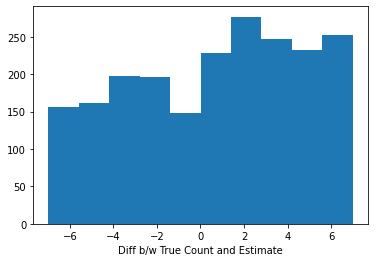

In [ ]:
cc_true, cc_pred = np.array(cc_true), np.array(cc_pred)
diff = cc_true - cc_pred
rmse = np.sqrt(np.mean(diff*diff))
mae = np.mean(np.abs(diff))
print(mae)
print(rmse)
print(np.mean(diff))
print(np.max(diff))
plt.hist(diff)
plt.xlabel("Diff b/w True Count and Estimate")
# plt.ylabel("Estimated")

**obtaining count by integration**

In [ ]:
pred_counts = []
for i in range(x2.shape[0]):
  _, x2[i] = cv2.threshold(x2[i], 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
  count = (np.sum(x2[i]) / 255) / (25)
  pred_counts.append(count)

In [ ]:
pred_counts = np.array(pred_counts)
diffs = (target - pred_counts)
sse = np.sum(diff * diff)
rmse = np.mean(np.sqrt(sse))
print(rmse)
np.mean(np.abs(target - pred_counts))

NameError: ignored

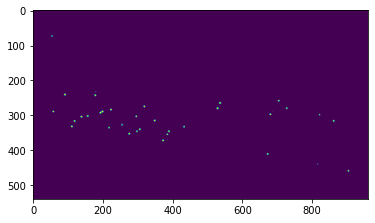

In [ ]:
plt.imshow(x2[0])

In [ ]:
x_train[0].shape

(270, 480)

In [ ]:
424/840

0.5047619047619047

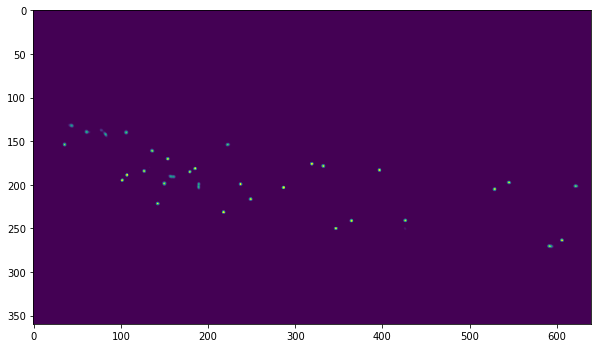

In [ ]:
plt.figure(figsize=(10, 20))
plt.imshow(pred[900])

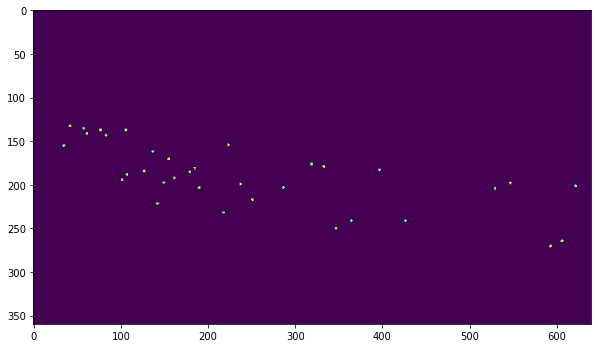

In [ ]:
plt.figure(figsize=(10, 20))
plt.imshow(y_test[1212])

In [ ]:
np.sum(y_test[140])

149

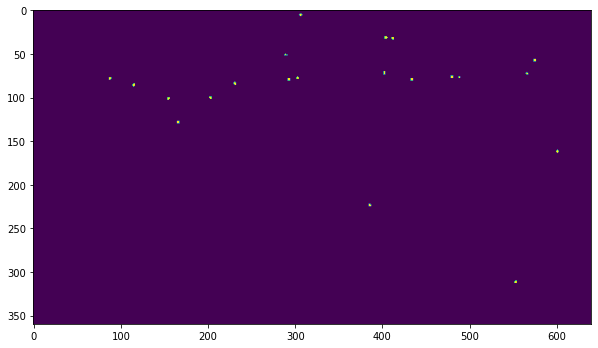

In [ ]:
plt.figure(figsize = (10, 20))
plt.imshow(x2[252])

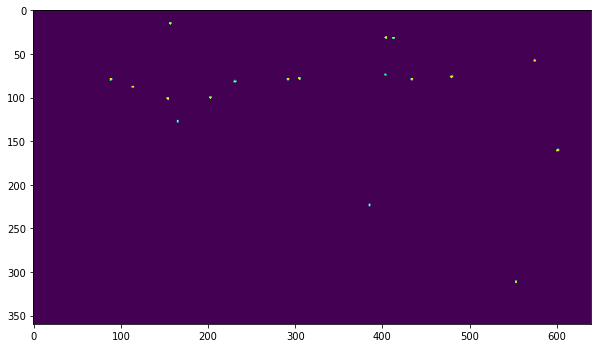

In [ ]:
plt.figure(figsize = (10, 20))
plt.imshow(y_test[252])

(array([ 12.,  61., 222., 505., 582., 373., 196.,  45.,  11.,   2.]),
 array([6.94736842, 7.09548872, 7.24360902, 7.39172932, 7.53984962,
        7.68796992, 7.83609023, 7.98421053, 8.13233083, 8.28045113,
        8.42857143]),
 <a list of 10 Patch objects>)

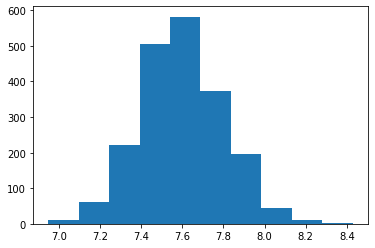

In [ ]:
plt.hist(q)